![title](static/wcar.png)

# ESAG3 iRNA in *Trypanosoma brucei*

## set up notebook

In [1]:
#!rm genomes/tb927_6/*

In [2]:
#reload when modified
%load_ext autoreload
%autoreload 2
#activate r magic
%load_ext rpy2.ipython
%matplotlib inline

In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import utilities as UT
import missingno as msno
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import gc
from io import StringIO
from itertools import islice
from Bio import SeqIO

random.seed(1976)
np.random.seed(1976)

In [4]:
import multiprocessing
multiprocessing.cpu_count()

56

# Data Anaylsis

In [5]:
!mkdir -p InData/CD_Search/
!mkdir -p InData

!gtf2bed < genomes/tb927_55/tb927_55.gtf > tb927_55.bed

In [6]:

!bedtools nuc -fi genomes/tb927_55/tb927_55.fa -bed tb927_55.bed > InData/GC_content_927.txt

#!cp genomes/tb927_3/tb927_3.gff .

!cp genomes/tb927_55/tb927_55.gtf .
!cp genomes/tb927_55/tb927_55.fa .
!cp genomes/tb927_55/tb927_55.fa.fai .

#!wget https://tritrypdb.org/common/downloads/Current_Release/TbruceiTREU927/gaf/TriTrypDB-50_TbruceiTREU927_GO.gaf -O InData/TriTrypDB-50_TbruceiTREU927_GO.gaf



## Experiment SetUp

In [7]:
from IPython.display import Image

In [8]:
#!less genomes/tb427/tb427.gff

In [9]:

#!wget https://tritrypdb.org/common/downloads/release-50/
#TbruceiLister427_2018/fasta/data/TriTrypDB-50_TbruceiLister427_2018_AnnotatedProteins.fasta 
#-O InData/TriTrypDB-50_TbruceiLister427_2018_AnnotatedProteins.fasta



In [10]:
'''
def chunk(it, size):
    it = iter(it)
    return iter(lambda: tuple(islice(it, size)), ())

out = []
record_dict = {}
with open("InData/TriTrypDB-50_TbruceiLister427_2018_AnnotatedProteins.fasta") as handle:
    for index, record in enumerate(SeqIO.parse(handle, "fasta")):
        record_dict['seq_'+str(index)] = record.id
        record.id = 'seq_'+str(index)
        out.append(record)
        #break


!mkdir -p InData/CD_Search/
for index,ch in enumerate(chunk(out, 3000)):
    fname = 'InData/CD_Search/indata_CD_Search_427_'+str(index)
    fout = open(fname, 'w')
    for record in ch:
        SeqIO.write( record,fout,'fasta')
    fout.close()
'''    

'\ndef chunk(it, size):\n    it = iter(it)\n    return iter(lambda: tuple(islice(it, size)), ())\n\nout = []\nrecord_dict = {}\nwith open("InData/TriTrypDB-50_TbruceiLister427_2018_AnnotatedProteins.fasta") as handle:\n    for index, record in enumerate(SeqIO.parse(handle, "fasta")):\n        record_dict[\'seq_\'+str(index)] = record.id\n        record.id = \'seq_\'+str(index)\n        out.append(record)\n        #break\n\n\n!mkdir -p InData/CD_Search/\nfor index,ch in enumerate(chunk(out, 3000)):\n    fname = \'InData/CD_Search/indata_CD_Search_427_\'+str(index)\n    fout = open(fname, \'w\')\n    for record in ch:\n        SeqIO.write( record,fout,\'fasta\')\n    fout.close()\n'

In [11]:


def get_fasta_desc(fasta_desc):
    res = {}
    for n in fasta_desc.split(" | "):
        if '=' in n:
            key = n.split('=')[0].strip()
            value = n.split('=')[1].strip()
            res[key]=value
    return res

# from io import StringIO
def read_csv(filename, comment='#', sep='\t', ):
    lines = "".join([line for line in open(filename) 
                     if not line.startswith(comment)])
    return pd.read_csv(StringIO(lines), sep=sep)

df_list = []
for f in ['/homes/mtinti/mtinti_2/DH_Douglas/vsg_victor/InData/CD_Search/927_{}_hitdata.txt'.format(n) for n in range(0,4)]:
    temp = read_csv(f)
    temp['seq_id'] = [n.split(' ')[2][1:] for n in temp['Query']]
    temp['gene_id'] = [get_fasta_desc(n)['gene'] for n in temp['Query']]
    df_list.append(temp)
df_domains=pd.concat(df_list)
df_domains.tail()



,Query,Hit type,PSSM-ID,From,To,E-Value,Bitscore,Accession,Short name,Incomplete,Superfamily,seq_id,gene_id
2016,Q#2196 - >seq_11195 Tb11.1690:pseudogenic_tran...,non-specific,395732,88,403,2.926680e-04,43.1506,pfam00913,Trypan_glycop,-,-,seq_11195,Tb11.1690
2017,Q#2196 - >seq_11195 Tb11.1690:pseudogenic_tran...,superfamily,287612,475,514,8.069620e-03,36.2338,cl11264,Trypan_glycop_C superfamily,C,-,seq_11195,Tb11.1690
2018,Q#2197 - >seq_11196 Tb11.1700:pseudogenic_tran...,non-specific,395732,216,516,9.775360e-07,50.8546,pfam00913,Trypan_glycop,-,-,seq_11196,Tb11.1700
2019,Q#2202 - >seq_11201 Tb11.1800:pseudogenic_tran...,superfamily,302859,1,387,4.186380e-164,478.5540,cl19421,RHSP superfamily,C,-,seq_11201,Tb11.1800
2020,Q#2203 - >seq_11202 Tb11.1810.1-p1 | transcrip...,superfamily,302859,1,222,7.326060e-103,315.2300,cl19421,RHSP superfamily,N,-,seq_11202,Tb11.1810


In [12]:
domain_dict = {}
for temp_id in df_domains.gene_id.unique():
    temp = df_domains[df_domains['gene_id']==temp_id]
    domains = list(temp['Short name'].values) 
    domains = '; '.join(domains)
    domain_dict[temp_id]=domains
domain_dict[list(domain_dict.keys())[0]]

'VSG_B; Trypan_glycop_C'

In [13]:
!wget https://tritrypdb.org/common/downloads/release-55/TbruceiTREU927/gff/data/TriTrypDB-55_TbruceiTREU927.gff -O InData/TriTrypDB-55_TbruceiTREU927.gff 

--2023-04-06 09:20:32--  https://tritrypdb.org/common/downloads/release-55/TbruceiTREU927/gff/data/TriTrypDB-55_TbruceiTREU927.gff
Resolving tritrypdb.org (tritrypdb.org)... 128.192.21.13
Connecting to tritrypdb.org (tritrypdb.org)|128.192.21.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9074123 (8.7M) [application/x-gff]
Saving to: ‘InData/TriTrypDB-55_TbruceiTREU927.gff’

InData/TriTrypDB-55 100%[===================>]   8.65M  2.16MB/s    in 4.3s    

2023-04-06 09:20:37 (2.03 MB/s) - ‘InData/TriTrypDB-55_TbruceiTREU927.gff’ saved [9074123/9074123]



In [14]:
#create a dictionary of gene to desc
#from the gff file
def make_desc(_GFF):
    gff =pd.read_csv( _GFF, sep='\t', header=None, comment='#')
    #print(gff)
    gff = gff[gff.iloc[:,2].str.contains('gene')]
    #print( gff[gff[gff.columns[-1]].str.contains('Tb427_020006200')] )
    #print(gff)
    desc = {}
    chr_dict = {}
    start_dict = {}
    sense_dict = {}
    for index,n in enumerate(gff.iloc[:,-1]):
        n=n.replace('%2C',' ')
        item_list = n.split(';')
        #print (item_list)
        temp_dict = {}
        for m in item_list:
            #print(m)
            temp_dict[m.split('=')[0].strip()]=m.split('=')[1].strip()
        #print(temp_dict['ID'])
        #print(temp_dict['description'])
        desc[temp_dict['ID']]=temp_dict.get('description','none')
        chr_dict[temp_dict['ID']]=gff.iloc[index][0]
        start_dict[temp_dict['ID']]=gff.iloc[index][3]
        sense_dict[temp_dict['ID']]=gff.iloc[index][6]
        
    return desc,chr_dict,start_dict,sense_dict

desc_dict_gff, _, _,_ = make_desc('InData/TriTrypDB-55_TbruceiTREU927.gff')

#(list(desc_dict.keys())[0],
# desc_dict[list(desc_dict.keys())[0]],
# chr_dict[list(desc_dict.keys())[0]],
# start_dict[list(desc_dict.keys())[0]],
#sense_dict[list(desc_dict.keys())[0]],
#)
#desc_dict_gff

In [15]:
#create a dictionary of gene to desc
#from the gff file
def make_desc(_GFF):
    gff =pd.read_csv( _GFF, sep='\t', header=None, comment='#')
    
    gff = gff[gff.iloc[:,2]=='exon']
    
    #print( gff[gff[gff.columns[-1]].str.contains('Tb427_020006200')] )
    desc = {}
    chr_dict = {}
    start_dict = {}
    sense_dict = {}
    for index,n in enumerate(gff.iloc[:,-1]):
        #print(n)
        n=n.replace('%2C',' ')
        item_list = n.split(';')
        item_list = [n for n in item_list if len(n)>0]
        temp_dict = {}
        
        for m in item_list:
            
            temp_dict[m.strip().split(' ')[0].strip().replace('\"','')
                     ]=m.strip().split(' ')[1].strip().replace('\"','')
        #print(temp_dict)
        #print(temp_dict['description'])
        desc[temp_dict['gene_id']]=temp_dict.get('description',temp_dict['gene_id'])
        chr_dict[temp_dict['gene_id']]=gff.iloc[index][0]
        start_dict[temp_dict['gene_id']]=gff.iloc[index][3]
        sense_dict[temp_dict['gene_id']]=gff.iloc[index][6]
        
    return desc,chr_dict,start_dict,sense_dict

desc_dict, chr_dict, start_dict,sense_dict = make_desc('genomes/tb927_55/tb927_55.gtf')
(list(desc_dict.keys())[0],
 desc_dict[list(desc_dict.keys())[0]],
 chr_dict[list(desc_dict.keys())[0]],
 start_dict[list(desc_dict.keys())[0]],
sense_dict[list(desc_dict.keys())[0]],
)

('gene-Tb427.BES40.1', 'gene-Tb427.BES40.1', 'FM162566.1', 1016, '+')

In [16]:
desc_dict.update(desc_dict_gff)

In [17]:
desc_dict['gene-Tb427.BES40.1']

'gene-Tb427.BES40.1'

In [18]:
desc_dict['gene-Tb427.BES40.1']

'gene-Tb427.BES40.1'

In [19]:
replace_list = eval(open('vars_def_927').read())
list_df = [n['experiment'] for n in replace_list]
list_df

['A25', 'A5', 'A9', 'B25', 'B5', 'B9', 'C25', 'C5', 'C9']

In [20]:
#read all the rna-seq reads counts for each sampe
#exp = '{life_stage}{replica}'
#list_df = [exp.format(
#    life_stage=life_stage,
#    replica=replica) 
# for life_stage in ['C','T']
# for replica in ['1','2','3']]

#aggregate counts in one dataframe
list_df = [n+'/res1_927/'+n+'/counts.txt' for n in list_df]
list_df =[pd.read_csv(n,index_col=[0],comment='#',sep='\t') for n in list_df]
df = list_df[0].copy()
for temp_df in list_df[1:]:
    df = df.join(temp_df.iloc[:,-1])
df.head()
#temp_df = pd.read_csv('BSF/tb927_3_ks_counts_final.txt',index_col=[0],comment='#',sep='\t')

,Chr,Start,End,Strand,Length,/tmp/1152422.1.all.q/A25/A25sorted.bam,/tmp/1152423.1.all.q/A5/A5sorted.bam,/tmp/1152424.1.all.q/A9/A9sorted.bam,/tmp/1152425.1.all.q/B25/B25sorted.bam,/tmp/1152426.1.all.q/B5/B5sorted.bam,/tmp/1152427.1.all.q/B9/B9sorted.bam,/tmp/1152428.1.all.q/C25/C25sorted.bam,/tmp/1152429.1.all.q/C5/C5sorted.bam,/tmp/1152430.1.all.q/C9/C9sorted.bam
Geneid,,,,,,,,,,,,,,
gene_Tb427VSG-3039,Tb427VSG-3039,1,1199,+,1199,4724,40009,32297,5768,34782,33738,5359,35395,32517
gene_Tb427VSG-23,Tb427VSG-23,1,1199,+,1199,413001,399661,432075,463670,326425,496225,464958,315900,490074
gene_Tb427VSG-649,Tb427VSG-649,1,1199,+,1199,445,2809,2263,689,2478,2570,473,2369,2581
gene_Tb427VSG-22,Tb427VSG-22,1,1199,+,1199,4794,8783,8118,4803,7957,8857,4996,7985,8579
gene_Tb427VSG-1117,Tb427VSG-1117,1,1199,+,1199,1,2,0,1,2,0,0,0,0


In [21]:
data_col = df.columns[5:]
data_col

Index(['/tmp/1152422.1.all.q/A25/A25sorted.bam',
       '/tmp/1152423.1.all.q/A5/A5sorted.bam',
       '/tmp/1152424.1.all.q/A9/A9sorted.bam',
       '/tmp/1152425.1.all.q/B25/B25sorted.bam',
       '/tmp/1152426.1.all.q/B5/B5sorted.bam',
       '/tmp/1152427.1.all.q/B9/B9sorted.bam',
       '/tmp/1152428.1.all.q/C25/C25sorted.bam',
       '/tmp/1152429.1.all.q/C5/C5sorted.bam',
       '/tmp/1152430.1.all.q/C9/C9sorted.bam'],
      dtype='object')

In [22]:
#rename columns for convenience
indata = df[data_col]
indata.columns = [n.split('/')[3] for  n in indata.columns]
indata.head()

,A25,A5,A9,B25,B5,B9,C25,C5,C9
Geneid,,,,,,,,,
gene_Tb427VSG-3039,4724,40009,32297,5768,34782,33738,5359,35395,32517
gene_Tb427VSG-23,413001,399661,432075,463670,326425,496225,464958,315900,490074
gene_Tb427VSG-649,445,2809,2263,689,2478,2570,473,2369,2581
gene_Tb427VSG-22,4794,8783,8118,4803,7957,8857,4996,7985,8579
gene_Tb427VSG-1117,1,2,0,1,2,0,0,0,0


In [23]:
data_col = df.columns[5:]
data_col

Index(['/tmp/1152422.1.all.q/A25/A25sorted.bam',
       '/tmp/1152423.1.all.q/A5/A5sorted.bam',
       '/tmp/1152424.1.all.q/A9/A9sorted.bam',
       '/tmp/1152425.1.all.q/B25/B25sorted.bam',
       '/tmp/1152426.1.all.q/B5/B5sorted.bam',
       '/tmp/1152427.1.all.q/B9/B9sorted.bam',
       '/tmp/1152428.1.all.q/C25/C25sorted.bam',
       '/tmp/1152429.1.all.q/C5/C5sorted.bam',
       '/tmp/1152430.1.all.q/C9/C9sorted.bam'],
      dtype='object')

In [24]:
print(indata.shape)
indata=indata.dropna()
print(indata.shape)
#indata.loc['KS17gene_1749a']
#indata['desc']=[desc_dict.get(n,'none') for n in indata.index.values]
#indata.to_csv('indata.csv')
#indata.head()
#indata.loc['mainVSG-427-2']
indata.sum()
#indata = indata.replace(1,np.nan).dropna(axis=1, how='all')
#print(indata.shape)
#indata.describe()

(11359, 9)
(11359, 9)


A25    26299148
A5     26708876
A9     26430383
B25    26961208
B5     26071360
B9     27472200
C25    27519739
C5     25760692
C9     27215312
dtype: int64

## QC - Missing Data Viz

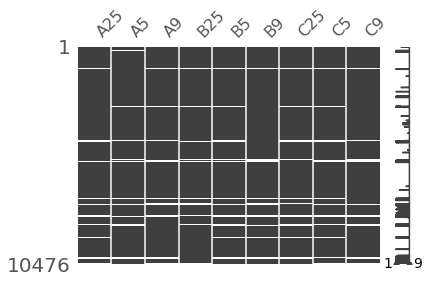

In [25]:
msno.matrix(indata.replace(0,np.nan).dropna(how='all'),figsize=(6, 4))

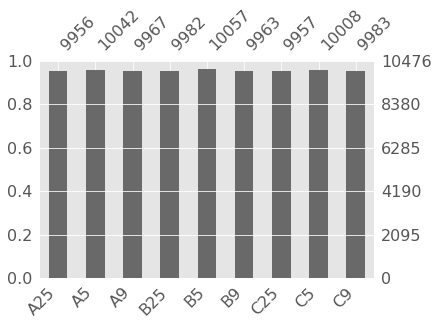

In [26]:
msno.bar(indata.replace(0,np.nan).dropna(how='all'),figsize=(6, 4))

## QC - Corr analysis

In [27]:
!mkdir -p Figures_927

(8.5, 0.5)


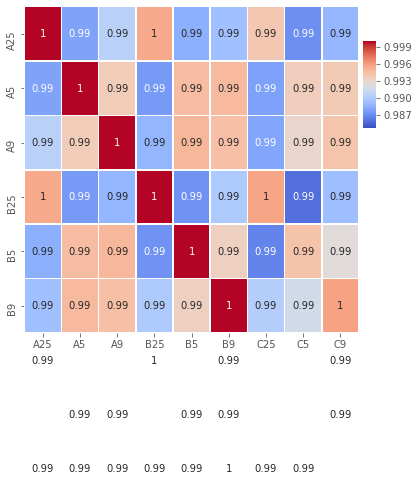

In [28]:
fig,ax=plt.subplots(figsize=(6,6))
cbar_ax = fig.add_axes([.91, .6, .03, .2])
sns.heatmap(np.log2(indata).corr(),
            #vmin=-1,
            cmap='coolwarm',
            annot=True,linewidths=.5,ax=ax, cbar_ax = cbar_ax, cbar=True)
print(ax.get_ylim())
ax.set_ylim(6,0)
plt.savefig('Figures_927/Figure_2.png')
plt.show()

In [30]:
indata.shape

(11359, 9)

In [31]:
indata.head()

,A25,A5,A9,B25,B5,B9,C25,C5,C9
Geneid,,,,,,,,,
gene_Tb427VSG-3039,4724,40009,32297,5768,34782,33738,5359,35395,32517
gene_Tb427VSG-23,413001,399661,432075,463670,326425,496225,464958,315900,490074
gene_Tb427VSG-649,445,2809,2263,689,2478,2570,473,2369,2581
gene_Tb427VSG-22,4794,8783,8118,4803,7957,8857,4996,7985,8579
gene_Tb427VSG-1117,1,2,0,1,2,0,0,0,0


## QC - MSD

{'r': 'A', 'b': 'B', 'y': 'C'}


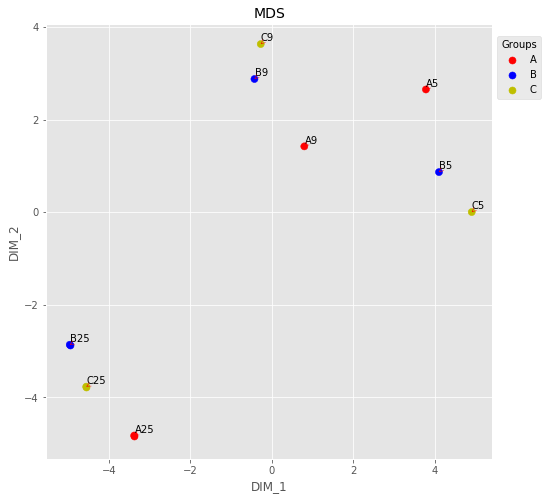

In [32]:
plt.style.use('ggplot')
palette = ['r']*3+['b']*3+['y']*3
fig,ax = plt.subplots(figsize=(8,8), ncols=1, nrows=1)
UT.make_mds(np.log2(indata),palette,ax,color_dictionary={'r':'A','b':'B','y':'C'
                                                        })
plt.savefig('Figures_927/Figure_3.png')
plt.show()

## Compute Length and GC content
this information is used to check for length and GC bias

In [33]:
!mkdir -p InData

In [34]:
!cp genomes/tb927_55/tb927_55.gtf .
!cp genomes/tb927_55/tb927_55.fa .
!cp genomes/tb927_55/tb927_55.fa.fai .

!gtf2bed < tb927_55.gtf > tb927_55.bed
!bedtools nuc -fi tb927_55.fa -bed tb927_55.bed >InData/GC_content_927.txt

In [35]:
#!bowtie2-build genomes/tb927_5/tb927_5.fa genomes/tb927_5/tb927_5

In [36]:
def get_gene_ids(n):
    res = {}
    temp = n.split(';')
    temp =[n.strip() for n in temp if len(n)>2]
    temp = temp[:2]
    #print(temp)
    for f in temp:
        key = f.split(' ')[0]
        value = f.split(' ')[1]
        key=key.replace('\"','').replace('\'','').strip()
        value=value.replace('\"','').replace('\'','').strip()
        res[key]=value
    return res['gene_id']

In [37]:
gc_content = pd.read_csv('InData/GC_content_927.txt',sep='\t')
gc_content = gc_content[gc_content['8_usercol']=='exon']
print(gc_content)
gc_content['gene_id'] = [get_gene_ids(n) for n in gc_content['10_usercol']]
gc_content = gc_content.drop_duplicates('gene_id')
gc_content.set_index('gene_id',inplace=True)
gc_content=gc_content[['19_seq_len','12_pct_gc']]
gc_content.columns = ['length', 'gccontent']
gc_content.loc['gene-Tb427.BES40.14']

                   #1_usercol  2_usercol  3_usercol      4_usercol 5_usercol  \
0                     11L3_v3      23857      29262   Tb07.11L3.90         .   
4                     11L3_v3      30223      48500  Tb07.11L3.100         .   
7                    5K5_v5.1          2         97    Tb05.5K5.10         .   
9                    5K5_v5.1        149       2405    Tb05.5K5.20         .   
12                   5K5_v5.1       3299       7701    Tb05.5K5.30         .   
...                       ...        ...        ...            ...       ...   
36761      tryp_XI-974h12.q1k       2573       7214      Tb11.1750         .   
36764      tryp_XI-974h12.q1k       7277       9272      Tb11.1760         .   
36767      tryp_XI-974h12.q1k       9336      14445      Tb11.1770         .   
36769  tryp_XI-976e03.p2kA567      14511      17218      Tb11.1800         .   
36773      tryp_XI-983f02.p1k      12277      13042      Tb11.1810         .   

      6_usercol  7_usercol 8_usercol 9_

length       1893.000000
gccontent       0.436873
Name: gene-Tb427.BES40.14, dtype: float64

In [38]:
#indata.head()
#indata.astype(int).to_csv('indata_427.csv',index=True)
#'E3KC','b':'E3KT','y':'E3SD','g':'P'

In [39]:
#metadata=pd.DataFrame()
#metadata['samples']=indata.columns
#metadata['treatment']=['E3KC','E3KC','E3KC','E3KT','E3KT','E3KT',
 #                     'E3SD','E3SD','E3SD','P','P','P']
#metadata['batch']=1
#metadata.reset_index().to_csv('metadata.csv')

In [40]:
print(indata.shape)
indata=indata.join(gc_content,how='inner')
gc_content = gc_content[['length', 'gccontent']]
indata.drop(['length', 'gccontent'],axis=1,inplace=True) 
indata.shape

(11359, 9)


(11317, 9)

### edgeR to filter low counts

In [41]:
%%R -i indata
options(warn=-1)
library("limma") 
library("edgeR")
head(indata)

                     A25    A5    A9   B25    B5    B9   C25    C5    C9
gene-Tb427.BES40.1  1241  1613  1564  1245  1479  1875  1536  1501  1716
gene-Tb427.BES40.2 25244 22253 16687 25677 23192 17098 26209 25043 16396
gene-Tb427.BES40.3 29462 26596 19183 30312 27289 19641 31505 29189 18610
gene-Tb427.BES40.4 19586 18109 18406 20382 19809 20028 19404 18798 19476
gene-Tb427.BES40.5 25206 21486 23702 23183 25897 19265 19330 26118 18241
gene-Tb427.BES40.6  2956  3163  2816  3089  3029  2838  2982  2728  3038


In [45]:
print(indata.shape)
indata.columns

(11317, 9)


Index(['A25', 'A5', 'A9', 'B25', 'B5', 'B9', 'C25', 'C5', 'C9'], dtype='object')

In [43]:
%%R
group <- factor(c(
    'A25', 'A5', 'A9', 'B25', 'B5', 'B9', 'C25', 'C5', 'C9'
))

y <- DGEList(counts=indata,group=group)
keep <- filterByExpr(y,min.count = 10, min.total.count = 80)
y <- y[keep,,keep.lib.sizes=FALSE]
counts = y$counts
genes = row.names(y)

In [46]:
%R -o counts,genes
indata = pd.DataFrame(counts,index=genes,columns=indata.columns)
indata.shape

(9604, 9)

In [47]:
indata=indata.join(gc_content,how='inner')
indata.shape

(9604, 11)

### GC / length content

In [48]:
gc_content = indata[['length', 'gccontent']]
indata.drop(['length', 'gccontent'],axis=1,inplace=True)
print(indata.shape,gc_content.shape)
indata.head()

(9604, 9) (9604, 2)


,A25,A5,A9,B25,B5,B9,C25,C5,C9
gene-Tb427.BES40.1,1241,1613,1564,1245,1479,1875,1536,1501,1716
gene-Tb427.BES40.2,25244,22253,16687,25677,23192,17098,26209,25043,16396
gene-Tb427.BES40.3,29462,26596,19183,30312,27289,19641,31505,29189,18610
gene-Tb427.BES40.4,19586,18109,18406,20382,19809,20028,19404,18798,19476
gene-Tb427.BES40.5,25206,21486,23702,23183,25897,19265,19330,26118,18241


### size factors

In [49]:
sizeFactors=indata.sum()
sizeFactors = sizeFactors.values
sizeFactors

array([25122151, 25594298, 25280636, 25596609, 25126155, 26169662,
       26172617, 24847331, 25938552])

In [50]:
#np.log2(gc_content['length']/1000).plot(kind='hist')

### Bias Correction

In [52]:
%%R -i gc_content,indata,sizeFactors
library(cqn)
library(scales)

In [53]:
%%R
stopifnot(all(rownames(indata) == rownames(gc_content)))
cqn.subset <- cqn(indata, lengths = gc_content$length,
                  x = gc_content$gccontent, sizeFactors = sizeFactors,
                  verbose = TRUE)

RQ fit .........
SQN .


In [54]:
#%R cqn.subset

### Viz Bias

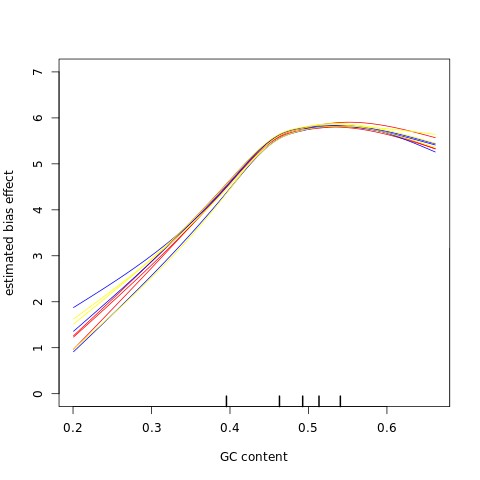

In [56]:
%%R
cqnplot <- function(x, n = 1, col = "grey60", ylab="estimated bias effect", 
                    xlab = "", type = "l", lty = 1, ...) {
    if(class(x) != "cqn")
        stop("'x' needs to be of class 'cqn'")
    if(n == 1) {
        func <- x$func1
        grid <- x$grid1
        knots <- x$knots1
    }
    if(n == 2) {
        if(is.null(x$func2))
            stop("argument 'x' does not appear to have two smooth functions (component 'func2' is NULL)")
        func <- x$func2
        grid <- x$grid2
        knots <- x$knots2
    }
    
    
    #par(mar=c(5.1, 4.1, 4.1, 8.1), xpd=TRUE)
    matplot(replicate(ncol(func), grid), func, ylab = ylab, xlab = xlab, type = type,
            col = col, lty = lty, ...)
    
    legend("bottomleft", legend = colnames(x$counts), inset=c(1,0),
           title="Samples", lty = lty, col = col)
    rug(knots, lwd = 2)
    invisible(x)
    
}


library(repr)
#options(repr.plot.width = 10, repr.plot.height = 0.75)
# Change plot size to 4 x 3
#options(repr.plot.width=4, repr.plot.height=3)


colors <- c(
    'red','red','red',
    'blue','blue','blue',
    'yellow','yellow','yellow'
)
lty =c(1,1,1,
       1,1,1,
      1,1,1

      )

#png("Figures/Figure_12.png")
#par(mfrow=c(1,2))
cqnplot(cqn.subset, col=colors,
        n = 1, xlab = "GC content", lty = lty,
        ylim = c(0, 7), 
        
       )
#dev.off()

#ggsave('plot.png', width=8.27, height= 11.69) #A4 size in inches
#dev.off()

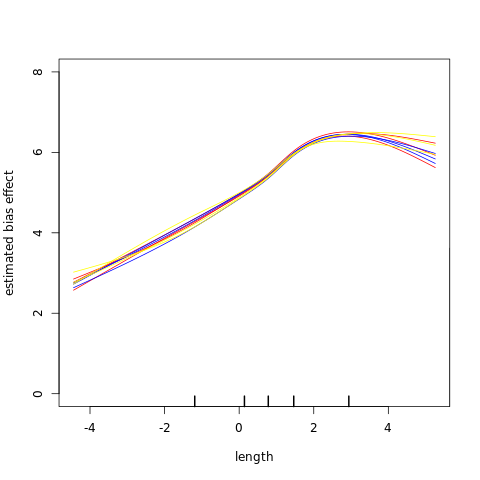

In [57]:
%%R
library(repr)
#options(repr.plot.width = 12, repr.plot.height = 0.75)
# Change plot size to 4 x 3
#options(repr.plot.width=8, repr.plot.height=3)


colors <- c(
    'red','red','red',
    'blue','blue','blue',
    'yellow','yellow','yellow'
)
lty =c(1,1,1,
       1,1,1,
      1,1,1

      )

#par(mfrow=c(1,2))
#png("Figures/Figure_13.png")
cqnplot(cqn.subset, col=colors,
        n = 2, xlab = "length", lty = lty,
        ylim = c(0,8), 
    
       )
#dev.off()

### Bias Correction

In [58]:
%%R
RPKM.cqn <- cqn.subset$y + cqn.subset$offset
out_table <- RPKM.cqn
head(out_table)

                         A25        A5        A9       B25        B5        B9
gene-Tb427.BES40.1  6.350010  6.553567  6.639943  6.297056  6.551557  6.848249
gene-Tb427.BES40.2 11.197895 10.913637 10.589694 11.080855 10.913637 10.647449
gene-Tb427.BES40.3 11.054428 10.892622 10.535865 11.004362 10.892622 10.548986
gene-Tb427.BES40.4 10.261617 10.172619 10.139384 10.271036 10.309778 10.271036
gene-Tb427.BES40.5 11.855725 11.698542 11.772027 11.855725 11.855725 11.698542
gene-Tb427.BES40.6  8.912608  9.072925  8.891549  8.975012  8.942098  8.955716
                         C25        C5        C9
gene-Tb427.BES40.1  6.532981  6.575449  6.728016
gene-Tb427.BES40.2 11.197895 11.028954 10.575893
gene-Tb427.BES40.3 11.166724 10.980588 10.510247
gene-Tb427.BES40.4 10.233956 10.207144 10.233956
gene-Tb427.BES40.5 11.855725 11.855725 11.698542
gene-Tb427.BES40.6  9.005906  8.776193  9.017319


In [59]:
#out_table

In [60]:
%R -o out_table
out_table = pd.DataFrame(out_table,index=indata.index.values,columns=indata.columns)
out_table.head()

,A25,A5,A9,B25,B5,B9,C25,C5,C9
gene-Tb427.BES40.1,6.350010,6.553567,6.639943,6.297056,6.551557,6.848249,6.532981,6.575449,6.728016
gene-Tb427.BES40.2,11.197895,10.913637,10.589694,11.080855,10.913637,10.647449,11.197895,11.028954,10.575893
gene-Tb427.BES40.3,11.054428,10.892622,10.535865,11.004362,10.892622,10.548986,11.166724,10.980588,10.510247
gene-Tb427.BES40.4,10.261617,10.172619,10.139384,10.271036,10.309778,10.271036,10.233956,10.207144,10.233956
gene-Tb427.BES40.5,11.855725,11.698542,11.772027,11.855725,11.855725,11.698542,11.855725,11.855725,11.698542


In [61]:
out_table.to_csv('RPKM_douglas.csv')
out_table

,A25,A5,A9,B25,B5,B9,C25,C5,C9
gene-Tb427.BES40.1,6.350010,6.553567,6.639943,6.297056,6.551557,6.848249,6.532981,6.575449,6.728016
gene-Tb427.BES40.2,11.197895,10.913637,10.589694,11.080855,10.913637,10.647449,11.197895,11.028954,10.575893
gene-Tb427.BES40.3,11.054428,10.892622,10.535865,11.004362,10.892622,10.548986,11.166724,10.980588,10.510247
gene-Tb427.BES40.4,10.261617,10.172619,10.139384,10.271036,10.309778,10.271036,10.233956,10.207144,10.233956
gene-Tb427.BES40.5,11.855725,11.698542,11.772027,11.855725,11.855725,11.698542,11.855725,11.855725,11.698542
...,...,...,...,...,...,...,...,...,...
Tb09.v4.0202,0.267215,0.550912,1.415622,0.267215,1.554972,-0.052848,-0.324635,1.038302,0.625319
Tb07.11L3.90,7.067177,7.207021,7.036434,7.136956,7.076955,7.254277,7.418831,6.747628,7.170852
Tb07.11L3.100,5.254706,5.482009,5.160641,5.266109,5.346416,5.218958,5.180826,5.274337,5.074366
Tb10.v4.0130,1.249394,-1.345721,-0.460458,0.754615,-0.324635,0.130765,0.625319,-0.324635,0.468290
